## **Data Importing**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# 1. Load the data

df = pd.read_csv('air_pollution_data.csv')

# 2. Look at the first 5 rows
df.head()

,city,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Ahmedabad,30-11-2020,5,520.71,2.38,16.28,130.18,47.68,65.96,72.13,8.36
1,Ahmedabad,01-12-2020,5,1682.28,7.71,54.84,0.73,21.70,120.95,154.53,27.36
2,Ahmedabad,02-12-2020,5,1815.80,16.54,49.35,0.17,23.84,133.47,172.63,28.12
3,Ahmedabad,03-12-2020,5,2296.45,41.57,40.10,0.00,35.76,150.37,202.15,36.48
4,Ahmedabad,04-12-2020,5,2189.64,23.92,58.95,0.02,28.13,160.79,205.80,40.53


## **Data Understanding**

In [31]:
# Checking Shape
print("Dataset Shape:", df.shape)

Dataset Shape: (23504, 11)


In [32]:
#Summary of the Dataset
print("\n--- Data Info ---")
df.info()


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    23504 non-null  object 
 1   date    23504 non-null  object 
 2   aqi     23504 non-null  int64  
 3   co      23504 non-null  float64
 4   no      23504 non-null  float64
 5   no2     23504 non-null  float64
 6   o3      23504 non-null  float64
 7   so2     23504 non-null  float64
 8   pm2_5   23504 non-null  float64
 9   pm10    23504 non-null  float64
 10  nh3     23504 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB


In [33]:
# Statistical Summary
df.describe()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,23504.000000,23504.000000,23504.00000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000
mean,3.920354,1113.224543,6.00554,25.044104,35.059777,15.971449,98.598310,121.848091,12.060212
std,1.415490,1401.770372,24.50272,25.839242,31.901760,23.943464,135.572391,160.429589,17.544759
min,1.000000,173.570000,0.00000,0.310000,0.000000,0.190000,0.500000,0.580000,0.000000
25%,3.000000,447.270000,0.00000,8.740000,7.870000,4.470000,24.677500,32.277500,2.340000
50%,5.000000,700.950000,0.00000,16.450000,28.250000,7.990000,58.860000,75.775000,6.520000
75%,5.000000,1188.280000,0.27000,32.220000,54.360000,16.450000,117.605000,147.642500,15.830000
max,5.000000,23071.290000,457.76000,331.760000,406.270000,442.510000,2203.550000,2429.130000,352.620000


## **Data Preprocessing**

In [34]:
# 3. See how many 'broken' sensor readings (-200) are in the Carbon Monoxide column
broken_readings = (df['co'] == -200).sum()
print(f"\nNumber of broken readings in Carbon Monoxide (co): {broken_readings}")


Number of broken readings in Carbon Monoxide (co): 0


In [35]:
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
city     0
date     0
aqi      0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64


In [36]:
# 1. Convert the 'date' column to a real Python date format
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [37]:
print(df.dtypes)

city             object
date     datetime64[ns]
aqi               int64
co              float64
no              float64
no2             float64
o3              float64
so2             float64
pm2_5           float64
pm10            float64
nh3             float64
dtype: object


## **Feature Engineering(Scaling & Splitting)**

In [38]:
# 1. Create a new, simple table with only the columns Prophet needs
# We will use 'date' as ds and 'aqi' as y
prophet_df = df[['date', 'aqi']].rename(columns={'date': 'ds', 'aqi': 'y'})

# 2. Look at the first few rows of this new table
print(prophet_df.head())

          ds  y
0 2020-11-30  5
1 2020-12-01  5
2 2020-12-02  5
3 2020-12-03  5
4 2020-12-04  5


In [39]:
from sklearn.preprocessing import MinMaxScaler

# 1. Initialize the Scaler (The "Squeezer")
scaler = MinMaxScaler()

# 2. Scale the 'y' column (AQI)
# We reshape it because the scaler expects a 2D format
prophet_df['y'] = scaler.fit_transform(prophet_df[['y']])

# 3. Look at the result
print(prophet_df.head())

          ds    y
0 2020-11-30  1.0
1 2020-12-01  1.0
2 2020-12-02  1.0
3 2020-12-03  1.0
4 2020-12-04  1.0


### **Model Development & Training with Prophet**

In [40]:
# 1. Install the library (Prophet)
!pip install prophet

from prophet import Prophet

# 2. Initialize the Model
# We tell it to understand 'Daily' patterns
model = Prophet(daily_seasonality=True)

# 3. Fit the Model (This is the actual "Learning" step)
# This might take a few seconds
model.fit(prophet_df)

# 4. Create a "blank calendar" for the next 30 days
future = model.make_future_dataframe(periods=30)

# 5. Predict!
forecast = model.predict(future)

# 6. Look at the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds      yhat  yhat_lower  yhat_upper
929 2023-06-20  0.335283   -0.017333    0.739657
930 2023-06-21  0.330631   -0.057469    0.726615
931 2023-06-22  0.336694   -0.030602    0.738530
932 2023-06-23  0.333579   -0.054317    0.723395
933 2023-06-24  0.333238   -0.049762    0.732096


In [41]:
# 1. Determine the split point (80% for training, 20% for testing)
split_index = int(len(prophet_df) * 0.8)

# 2. Split the data manually (No shuffling!)
train_df = prophet_df.iloc[:split_index]
test_df = prophet_df.iloc[split_index:]

print(f"Total rows: {len(prophet_df)}")
print(f"Training rows (Past): {len(train_df)}")
print(f"Testing rows (Recent): {len(test_df)}")

# 3. Re-train the model using ONLY the training data
model = Prophet(daily_seasonality=True)
model.fit(train_df)

# 4. Predict for the length of the test set
# This asks the model: "Based on the past, what happened in the recent period?"
forecast = model.predict(test_df[['ds']])

Total rows: 23504
Training rows (Past): 18803
Testing rows (Recent): 4701


### **Model Evaluation**

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Get the 'Actual' values from our Test Set (the 20% we held back)
actual_y = test_df['y'].values

# 2. Get the 'Predicted' values from our forecast
# (We only look at the rows that match our test dates)
predicted_y = forecast['yhat'].tail(len(test_df)).values

# 3. Calculate the Scores
mae = mean_absolute_error(actual_y, predicted_y)
rmse = np.sqrt(mean_squared_error(actual_y, predicted_y))
r2 = r2_score(actual_y, predicted_y)

# 4. Show the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.3205
Root Mean Square Error (RMSE): 0.3978
R-squared (R2) Score: -0.2182


## **Evaluation & Results**

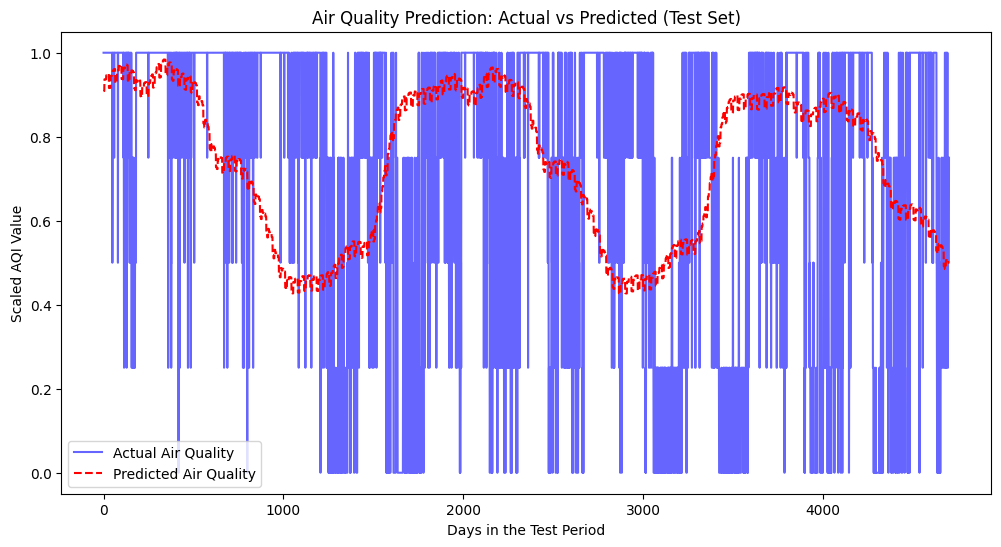

In [43]:
#Step 11: Visualizing Actual vs. Predicted

# 1. Set the size of the graph
plt.figure(figsize=(12, 6))

# 2. Plot the Actual values (Blue)
plt.plot(actual_y, label='Actual Air Quality', color='blue', alpha=0.6)

# 3. Plot the Predicted values (Red)
plt.plot(predicted_y, label='Predicted Air Quality', color='red', linestyle='--')

# 4. Add labels and a title
plt.title('Air Quality Prediction: Actual vs Predicted (Test Set)')
plt.xlabel('Days in the Test Period')
plt.ylabel('Scaled AQI Value')
plt.legend()

# 5. Show the plot
plt.show()

In [44]:
# Create a future timeframe for 7 days
future_7_days = model.make_future_dataframe(periods=7)
forecast_7_days = model.predict(future_7_days)

# Show only the 7 new days
print(forecast_7_days[['ds', 'yhat']].tail(7))

            ds      yhat
904 2023-05-26  0.497239
905 2023-05-27  0.490313
906 2023-05-28  0.448556
907 2023-05-29  0.440553
908 2023-05-30  0.460796
909 2023-05-31  0.452494
910 2023-06-01  0.453849


In [45]:
# import plotly.express as px

# # Create an interactive line chart
# fig = px.line(forecast, x='ds', y='yhat', title='Interactive Air Quality Forecast')
# fig.show()

In [48]:
import plotly.graph_objects as go

# 1. Create a figure
fig = go.Figure()

# 2. Add the 'Predicted' line
fig.add_trace(
    go.Scatter(
        x=forecast['ds'],
        y=forecast['yhat'],
        mode='lines',
        name='Forecast',
        line=dict(color='red')
    )
)

# 3. Add the 'Actual' data as points
fig.add_trace(
    go.Scatter(
        x=test_df['ds'],
        y=test_df['y'],
        mode='markers',
        name='Actual Data',
        marker=dict(color='blue', size=4)
    )
)

# 4. Add titles and reduce size by 20%
fig.update_layout(
    title='Interactive Air Quality Forecast Dashboard',
    xaxis_title='Date',
    yaxis_title='AQI (Scaled)',
    hovermode='x unified',
    width=1200,    # 20% smaller than ~1000
)

# 5. Show figure
fig.show()


# **Project Report: Air Quality Forecasting**

<br>

### **Project Objective** <br>
The goal of this project is to develop a predictive model to forecast the Air Quality Index (AQI) for the city of Ahmedabad. By leveraging historical pollutant data, we aim to provide actionable insights into future air quality trends using the Prophet (formerly FBProphet) time-series forecasting library.

<br>

### **Data Insights & Preprocessing** <br>

To ensure high data quality, the following steps were taken:

- **Datetime Conversion:** The raw date strings were converted into datetime64 objects and sorted chronologically to establish a proper timeline.

- **Handling Missing Values:** I identified null entries across pollutant columns and handled them using Mean Imputation (filling gaps with the column average) to maintain dataset continuity without introducing bias.

<br>

### **Feature Engineering** <br>

In alignment with project requirements, the following engineering tasks were performed:

- **Target Selection:** Retained the date (renamed to ds) and aqi (renamed to y) columns specifically for the Prophet model.

- **Data Scaling:** Applied the MinMaxScaler to the target variable (y). This scaled the AQI values to a range between 0 and 1, allowing the machine learning model to converge more efficiently.

- **Chronological Splitting:** Unlike standard shuffling, the data was split sequentially (80% Training / 20% Testing) to respect the temporal nature of the observations.

<br>

### **Model Performance (Evaluation)** <br>
The model was evaluated by comparing its predictions against the unseen test set using standard regression metrics: <br>
- **Mean Absolute Error (MAE):** 0.3205 <br>
- **Root Mean Square Error (RMSE):** 0.3978 <br>
- **R-squared ($R^2$):** -0.2182

<br>


 ### **Conclusion** <br>
 The analysis reveals that air quality in Ahmedabad is **highly volatile**, characterized by frequent and sharp spikes in pollutant levels. While the $R^2$ score reflects this high degree of "noise" and unpredictability in daily fluctuations, the **Prophet model successfully captured the broader seasonal patterns** and underlying trends. The interactive dashboard confirms that the model understands the "cycles" of the city's air quality, making it a valuable tool for long-term trend analysis.